In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer
from tensorflow.keras import  Model
import time
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
import os
from google.colab import drive


In [2]:
import os

SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './turtle_recall/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
  %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
  %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
  %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')
#for entry in os.listdir(IMAGE_DIR):
  #print(entry)

The total number of images is: 13891


In [3]:
import pandas as pd
import requests
import io
import urllib.parse

BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'


def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))


# Read in csv files.
train = read_csv_from_web('train.csv')
#print(train)
test = read_csv_from_web('test.csv')
#print(test)
sample_submission = read_csv_from_web('sample_submission.csv')

# Convert image_location strings to lowercase.
for df in [train, test]:
  #print(df)
  df.image_location = df.image_location.apply(lambda x: x.lower())
  #print(df.image_location)
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

In [4]:
turtle_ids = sorted(np.unique(train.turtle_id)) + ['new_turtle']
#print(turtle_ids)
labels = dict(zip(turtle_ids, np.arange(len(turtle_ids))))
#print(labels)
label_lookup = {v: k for k, v in labels.items()}
#print(label_lookup)
num_classes = len(labels)
#print(num_classes)
image_to_turtle = dict(zip(train.image_id, train.turtle_id))
#print(image_to_turtle)

image_files = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)
              if f.split('.')[0] in train.image_id.values]
#print(image_files)

image_ids = [os.path.basename(f).split('.')[0] for f in image_files]
#print(image_ids)
image_turtle_ids = [image_to_turtle[id] for id in image_ids]
#print(image_turtle_ids)
keys=[]
for tid in image_turtle_ids:              #generating labels
  for key, vals in label_lookup.items():
    if(tid==vals):
      keys.append(key)
#print(keys)




In [5]:
import tqdm
from PIL import Image 
from numpy import asarray
def crop_and_resize(pil_img):
  """Crops square from center of image and resizes to (224, 224)."""
  w, h = pil_img.size
  crop_size = min(w, h)
  crop = pil_img.crop(((w - crop_size) // 2, (h - crop_size) // 2,
                       (w + crop_size) // 2, (h + crop_size) // 2))
  return crop.resize((224, 224))


tqdm.tqdm._instances.clear()
loaded_images = [crop_and_resize(Image.open(f)) for f in tqdm.tqdm(image_files)]




100%|██████████| 2145/2145 [01:34<00:00, 22.66it/s]


In [6]:
tensor_list=[]
from numpy import asarray
for x in loaded_images:
  #print(x)
  #x.show()
  data = asarray(x)                             #converting PIL image to numpy array
  t=tf.convert_to_tensor(data, dtype=tf.float32)
  #print(t)
  tensor_list.append(t)




In [7]:
full_ds = tf.data.Dataset.from_tensor_slices((tensor_list,keys))
#print(new_ds)
#for x,y in new_ds.take(4):
  #print(x,y)
full_ds=full_ds.map(lambda img, target: ((img, tf.one_hot(target, depth=101))))
#full_ds = full_ds.batch(32)

df = pd.read_csv('https://storage.googleapis.com/dm-turtle-recall/train.csv', delimiter= ';')
(rows,cols) = df.shape


train_ds = full_ds.take(int(0.6*rows))
remaining = full_ds.skip(int(0.4*rows))
#valid_ds = remaining.take(int(0.2*rows))
train_ds = train_ds.batch(16)
test_ds = remaining.take(int(0.4*rows))
test_ds = test_ds.batch(16)

#for x,y in train_ds.take(5):
  #print(x,y)

In [8]:
#batch_size = 32
#AUTOTUNE = tf.data.AUTOTUNE

#def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  #ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              #num_parallel_calls=AUTOTUNE)

  #if shuffle:
    #ds = ds.shuffle(1000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  #if augment:
    #ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                #num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  #return ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
#train_ds = prepare(train_ds, shuffle=True, augment=True)
#val_ds = prepare(val_ds)
#test_ds = prepare(test_ds)

In [10]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

In [11]:
efficientnet = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
classifier_model = efficientnet

In [12]:
IMAGE_SHAPE = (224, 224)



In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
class MyModel(tf.keras.Model):
   def __init__(self):
     super(MyModel, self).__init__()
     self.base_model = hub.KerasLayer(classifier_model, trainable=False,input_shape=IMAGE_SHAPE + (3,))
     #self.base_model.trainable = False
     self.out1=tf.keras.layers.Dropout(rate=0.2)
     self.out2=tf.keras.layers.Dense(101,kernel_regularizer=tf.keras.regularizers.l2(0.0001),activation='softmax')
     self.input1=tf.keras.Input(shape=(224,224,3))

   @tf.function
   def call(self, inputs):




      #x = self.input1(inputs)

      x = self.base_model(inputs)

      x = self.out1(x)

      x = self.out2(x)
      return x


In [18]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

Epoch: 0 starting with accuracy 0.006944444444444444
 After Epoch: 1 accuracy: 0.006944444444444444
Epoch: 1 starting with accuracy 0.1048611111111111
 After Epoch: 2 accuracy: 0.1048611111111111
Epoch: 2 starting with accuracy 0.17662037037037037
 After Epoch: 3 accuracy: 0.17662037037037037
Epoch: 3 starting with accuracy 0.2611111111111111
 After Epoch: 4 accuracy: 0.2611111111111111
Epoch: 4 starting with accuracy 0.3300925925925926
 After Epoch: 5 accuracy: 0.3300925925925926
Epoch: 5 starting with accuracy 0.3851851851851852
 After Epoch: 6 accuracy: 0.3851851851851852
Epoch: 6 starting with accuracy 0.4175925925925926
 After Epoch: 7 accuracy: 0.4175925925925926
Epoch: 7 starting with accuracy 0.45046296296296295
 After Epoch: 8 accuracy: 0.45046296296296295
Epoch: 8 starting with accuracy 0.4886574074074074
 After Epoch: 9 accuracy: 0.4886574074074074
Epoch: 9 starting with accuracy 0.5013888888888889
 After Epoch: 10 accuracy: 0.5013888888888889
Epoch: 10 starting with accurac

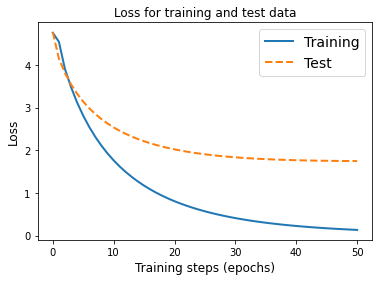

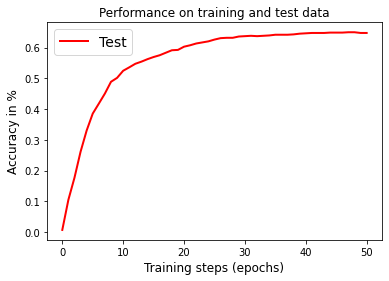

In [20]:
num_epochs = 50
learning_rate = 0.001
start = time.time()
# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)



train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f' After Epoch: {str(epoch+1)} accuracy: {test_accuracies[epoch]}') 


end = time.time()
duration = end - start


print(f'  After Training of {str(epoch+1)} Epochs test accuracy: {test_accuracies[49]}')

print('The training took ', str(int(duration / 60)), ' minutes and ', str(duration % 60), ' seconds.' )

import matplotlib.pyplot as plt
plt.figure()
line1, = plt.plot(train_losses, linewidth = 2)
line2, = plt.plot(test_losses, linestyle = 'dashed', linewidth = 2)
#line3, = plt.plot(validation_losses, linewidth = 2)
plt.xlabel("Training steps (epochs)", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend((line1,line2),("Training","Test"), fontsize = 14)
plt.title("Loss for training and test data")
plt.show()
# One plot for training and test accuracy.
plt.figure()
#line1, = plt.plot(train_accuracies, linestyle = 'dashed', color = 'green', linewidth = 2)
line3, = plt.plot(test_accuracies, color = 'red', linewidth = 2)
#line3, = plt.plot(validation_accuracies, color = 'blue', linewidth = 2)
plt.xlabel("Training steps (epochs)", fontsize = 12)
plt.ylabel("Accuracy in %", fontsize = 12)
plt.legend([line3],["Test"], fontsize = 14)
plt.title("Performance on training and test data")
plt.show()
